# Data Scientist Professional Practical Exam Submission

## 📝 Task List

This notebook includes both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake


**Importing relevant packages**

In [3]:
# ============================================================================
# IMPORT REQUIRED LIBRARIES AND MODULES
# ============================================================================
# Standard scientific computing libraries
import warnings

import numpy as np
from scipy.stats import zscore
from sklearn.model_selection import train_test_split

from model_development import LogisticRegressionModel, RandomForestModel
from model_evaluation import ModelEvaluator
from utils import DataExplorer, FeatureEngineering, ModelInterpreter, StatisticalTester
from validation import DataValidator
from visualization import DataVisualizer, ModelVisualizer

# Suppress all warnings for cleaner output
warnings.filterwarnings("ignore")

# Initialize explorers and handlers for use throughout notebook
explorer = DataExplorer()
fe = FeatureEngineering()
visualizer = DataVisualizer()
model_viz = ModelVisualizer()

# Data Import, validation, and cleaning 

In [4]:
# ============================================================================
# LOAD AND EXAMINE DATA
# ============================================================================
# Define column names for validation and analysis
num_cols = ["calories", "carbohydrate", "sugar", "protein"]
cat_cols = ["category", "servings"]
id_col = "recipe"
target_col = "high_traffic"

# Load the recipe traffic dataset from CSV file and display examination info
df = explorer.load_and_examine_data("recipe_site_traffic_2212.csv")

=== DataFrame Info ===
<class 'pandas.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    str    
 6   servings      947 non-null    str    
 7   high_traffic  574 non-null    str    
dtypes: float64(4), int64(1), str(3)
memory usage: 59.3 KB
None

=== General Stats for All Columns ===
              count unique        top freq        mean         std   min  \
recipe        947.0    NaN        NaN  NaN       474.0  273.519652   1.0   
calories      895.0    NaN        NaN  NaN  435.939196  453.020997  0.14   
carbohydrate  895.0    NaN        NaN  NaN   35.069676   43.949032  0.03   
sugar         895.0    NaN        NaN  NaN    9

**Initial comments**
- There are 947 entries
- There are many missings in the column high_traffic, but given the assignment it might be that only observation with high traffic have been coded in the high_traffic column. This intuition is supported by the fact that there is only 1 unique value. It deserves further investigation.
- There are 52 missings in the numerical columns (calories, carbohydrate, sugar, protein). They all have same number of missings, they might be observation with completely missing information over those columns. It deserves further investigation
- Good news: no missings in the identifier column named recipe, minimum is 1 and max 947 with int dtype. It looks a legitimate identifier column, but I will test if each recipe has unique number.
- The column category should have 10 unique values, it has 11. It will be furtherly investigated.
- The column servings should be numerical type (float or int), but it is object type, probably mixed dtypes in the column. It will be investigated.
- The column servings has only limited amount of unique values even though officially should be numerical. It will be considered as categorical in the analysis for this reason.

In [5]:
# ============================================================================
# CHECK FOR MISSING VALUES AND DATA INTEGRITY
# ============================================================================
# Check for missing values and verify data integrity
explorer.check_data_integrity(df, id_col=id_col, target_col=target_col)


=== Missing Values ===
recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

Unique IDs: 947, Total: 947

Unique high_traffic values:
<StringArray>
['High', nan]
Length: 2, dtype: str
high_traffic
High    574
Name: count, dtype: int64


In [6]:
# ============================================================================
# CHECK FOR MISSING VALUES AND DATA INTEGRITY
# ============================================================================
# Define column names for later use throughout the analysis
num_cols = ["calories", "carbohydrate", "sugar", "protein"]
cat_cols = ["category", "servings"]
id_col = "recipe"
target_col = "high_traffic"

# Check for missing values
print("\n=== Missing Values ===")
print(df.isnull().sum())

# Verify that recipe identifiers are unique
unique_ids = df[id_col].nunique()
total_ids = len(df[id_col])
print(f"\nUnique IDs: {unique_ids}, Total: {total_ids}")
if unique_ids != total_ids:
    print("WARNING: Recipe IDs are not unique!")

# Examine the target variable
print(f"\nUnique {target_col} values:")
print(df[target_col].unique())
print(df[target_col].value_counts())


=== Missing Values ===
recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

Unique IDs: 947, Total: 947

Unique high_traffic values:
<StringArray>
['High', nan]
Length: 2, dtype: str
high_traffic
High    574
Name: count, dtype: int64


**Detecting missings**
- The recipe column (which is the identifier column) has 947 unique int values for 947 entries, with minimum 1 and max 947. It is a legitimate identifier column. 
- The count of missing for calories, carbohydrate, sugar and protein is confirmed. Further analysis on the outliers will come afterwards.
- 373 Missings for the target column high_traffic, 1 unique value which is "High". The values of the column high_traffic has been coded as "High" only when the observation leads to higher web traffic, in all other cases it is missing. The column will be changed ahead to a boolean column with value True if the current value is "High" and to False when it is missing.  

In [7]:
# ============================================================================
# VALIDATE CATEGORICAL COLUMNS
# ============================================================================
# Define expected categories for validation
expected_categories = {
    "Lunch/Snacks",
    "Beverages",
    "Potato",
    "Vegetable",
    "Meat",
    "Chicken",
    "Pork",
    "Dessert",
    "Breakfast",
    "One Dish Meal",
}

# Validate categorical columns
explorer.validate_categorical_columns(df, expected_categories=expected_categories)


Unique category values:
<StringArray>
[          'Pork',         'Potato',      'Breakfast',      'Beverages',
  'One Dish Meal', 'Chicken Breast',   'Lunch/Snacks',        'Chicken',
      'Vegetable',           'Meat',        'Dessert']
Length: 11, dtype: str
category
Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: count, dtype: int64

Categories not in expected set:
{'Chicken Breast'}
Categories missing from dataset (but expected):
set()

Unique servings values:
<StringArray>
['6', '4', '1', '2', '4 as a snack', '6 as a snack']
Length: 6, dtype: str
servings
4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: count, dtype: int64


**Validation and cleaning of servings and category**
- There is no particularly uneven distribution across the categories. The most frequent is "breakfast", the least frequent is "One Dish Meal". However, we can see that one category is not supposed to be there, which is "Chicken Breast". All cases where category = "Chicken Breast" will be recoded to "Chicken". This will make "Chicken" the new most frequent category.
- The column "servings" is supposed to be numerical, but it has 2 text unique values in 3 observations. They are "4 as a snack" and "6 as a snack". They will respectively be recoded to 4 and 6, and the column converted to int dtype. 

In [8]:
# ============================================================================
# CLEAN AND VALIDATE DATA USING DATAVALIDATOR CLASS
# ============================================================================
# Initialize the DataValidator with our dataset
validator = DataValidator(df)

# Perform validation and cleaning
# This handles: category standardization, servings extraction, and target recoding
df_cleaned = validator.validate_and_clean()

# Display results after cleaning
explorer.display_cleaning_results(
    df_cleaned, target_col=target_col, expected_categories=expected_categories
)


Categories not in expected set:
set()
Categories missing from dataset (but expected):
set()

Servings value counts after cleaning:
servings
1    175
2    183
4    391
6    198
Name: count, dtype: Int64

Unique high_traffic values after recoding:
[ True False]
high_traffic
True     574
False    373
Name: count, dtype: int64


**Declared changes on our target variable "high_traffic" and category have been applied**
- high_traffic changed to a boolean column where missings are False and values "High" are True
- the category "Chicken Breast" has been changed to "Chicken" and no further missings, or unexpected categories are present
- the mixed type issue of the column "servings" has been solved changing the values "4 as a snack" and "6 as a snack" into 4 and 6

In [9]:
# ============================================================================
# EXAMINE ROWS WITH MISSING VALUES
# ============================================================================
# Display rows that still have missing values
df_missing = explorer.display_missing_rows(df_cleaned, num_rows=10)

Sample of rows with missing values:
     recipe  calories  carbohydrate  sugar  protein       category  servings  \
0         1       NaN           NaN    NaN      NaN           Pork         6   
23       24       NaN           NaN    NaN      NaN           Meat         2   
48       49       NaN           NaN    NaN      NaN        Chicken         4   
82       83       NaN           NaN    NaN      NaN           Meat         4   
89       90       NaN           NaN    NaN      NaN           Pork         6   
116     117       NaN           NaN    NaN      NaN        Chicken         6   
121     122       NaN           NaN    NaN      NaN        Dessert         2   
136     137       NaN           NaN    NaN      NaN  One Dish Meal         2   
149     150       NaN           NaN    NaN      NaN         Potato         2   
187     188       NaN           NaN    NaN      NaN           Pork         4   

     high_traffic  
0            True  
23          False  
48          False  
82 

**Dealing with missings in the numerical columns**

As suspected, the missings in calories, carbohydrate, sugar, and protein are missing in all 4 columns. 
Since there are a few missing values, dropping them would result in prediction power loss and potentially also in selection bias. To reduce the probability of selection bias and protect the prediction power of our data I will impute those missing values using the mean of their respective columns. 
I suspect a correlation with the column "category", so I will test this hypothesis using ANOVA test (numerical columns with categorical columns need ANOVA). If these columns show correlation with "category" I will impute using the clustered mean by 'category'. I will also do an ANOVA test with the column servings (please remember, I treat servings as categorical because it has few unique values), but since the nutritional values that we have are par serving, I do not expect a significant correlation. 

In [10]:
# ============================================================================
# PERFORM ANOVA TESTS FOR FEATURE CORRELATION
# ============================================================================
# Test correlation between numerical features and category
print("ANOVA test for nutritional numerical columns with the column category")
StatisticalTester.anova_test_multiple(df=df_cleaned, num_cols=num_cols, cat_col="category")

# Test correlation between numerical features and servings
print("\nANOVA test for nutritional numerical columns with the column servings")
StatisticalTester.anova_test_multiple(df=df_cleaned, num_cols=num_cols, cat_col="servings")

ANOVA test for nutritional numerical columns with the column category
ANOVA for 'calories' by Category: F = 11.200, p = 0.000
ANOVA for 'carbohydrate' by Category: F = 11.020, p = 0.000
ANOVA for 'sugar' by Category: F = 47.312, p = 0.000
ANOVA for 'protein' by Category: F = 29.528, p = 0.000

ANOVA test for nutritional numerical columns with the column servings
ANOVA for 'calories' by Servings: F = 0.989, p = 0.397
ANOVA for 'carbohydrate' by Servings: F = 0.318, p = 0.812
ANOVA for 'sugar' by Servings: F = 0.098, p = 0.961
ANOVA for 'protein' by Servings: F = 0.442, p = 0.723


{'calories': {'F-statistic': '0.989', 'p-value': '0.397'},
 'carbohydrate': {'F-statistic': '0.318', 'p-value': '0.812'},
 'sugar': {'F-statistic': '0.098', 'p-value': '0.961'},
 'protein': {'F-statistic': '0.442', 'p-value': '0.723'}}

**My expectations are correct** 
 
The numerical columns are correlated with the category, but not with servings. 
I proceed with the imputation of the mean of the respective columns grouping the observations by their value in the column 'category'.

In [11]:
# ============================================================================
# IMPUTE MISSING NUMERICAL VALUES
# ============================================================================
# Use DataValidator's imputation method to fill missing values with
# category-wise means. This preserves the distribution within each category.
df_imputed = validator.impute_numerical_values(num_cols=num_cols, group_by_col="category")

# Compare statistics before and after imputation to ensure no bias introduced
for col in num_cols:
    print(f"===Data distribution in dataframe with imputed values for {col}===")
    print(
        f"{col}: min = {df_imputed[col].min()}, max = {df_imputed[col].max()}, "
        f"mean = {df_imputed[col].mean()}, median = {df_imputed[col].median()}"
    )
    print(f"===Data distribution in dataframe with missing values for {col}===")
    print(
        f"{col}: min = {df_cleaned[col].min()}, max = {df_cleaned[col].max()}, "
        f"mean = {df_cleaned[col].mean()}, median = {df_cleaned[col].median()}"
    )

===Data distribution in dataframe with imputed values for calories===
calories: min = 0.14, max = 3633.16, mean = 439.39360084477295, median = 309.05
===Data distribution in dataframe with missing values for calories===
calories: min = 0.14, max = 3633.16, mean = 435.9391955307263, median = 288.55
===Data distribution in dataframe with imputed values for carbohydrate===
carbohydrate: min = 0.03, max = 530.42, mean = 35.14456177402323, median = 23.06
===Data distribution in dataframe with missing values for carbohydrate===
carbohydrate: min = 0.03, max = 530.42, mean = 35.06967597765363, median = 21.48
===Data distribution in dataframe with imputed values for sugar===
sugar: min = 0.01, max = 148.75, mean = 9.058870116156283, median = 4.97
===Data distribution in dataframe with missing values for sugar===
sugar: min = 0.01, max = 148.75, mean = 9.04654748603352, median = 4.55
===Data distribution in dataframe with imputed values for protein===
protein: min = 0.0, max = 363.36, mean = 24

Very good! The main distribution statistics of the imputed columns did not have any big change. So, no bias has been introduced as expected. 

In [12]:
# ============================================================================
# VERIFY NO MISSING VALUES AFTER IMPUTATION
# ============================================================================
# Confirm that imputation was successful and dataset is complete
print("\n=== Missing Values After Imputation ===")
print(df_imputed.isnull().sum())


=== Missing Values After Imputation ===
recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64


Data does not have anymore missing. Data is now ready for exploratory analysis.

I now can go ahead with the exploratory analysis

____________________________________________________________________________________________________

# Exploratory analysis

**Distribution Analysis**

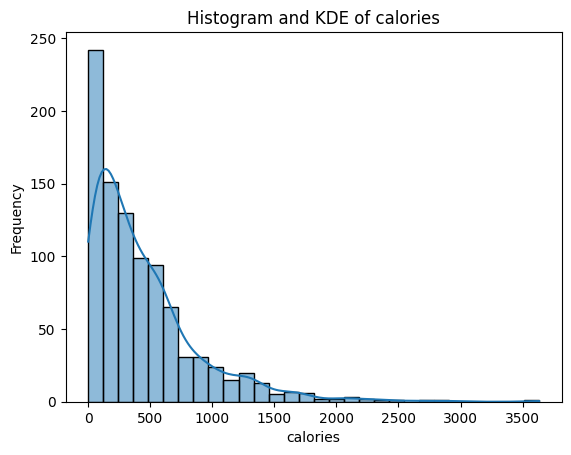

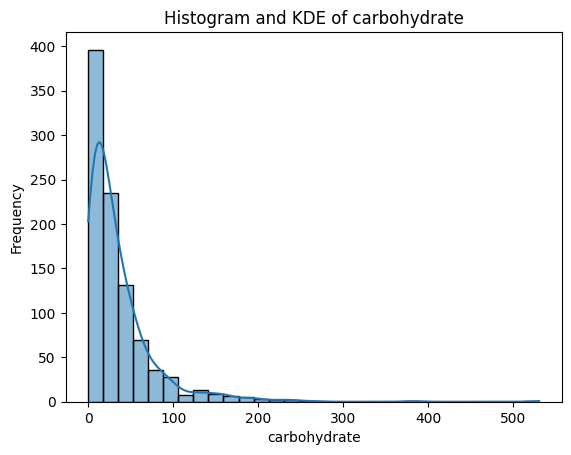

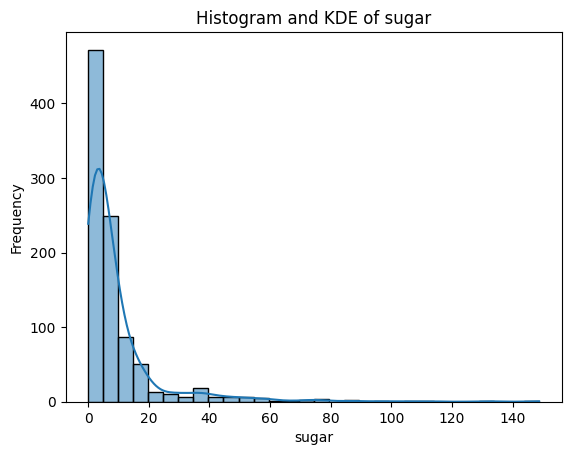

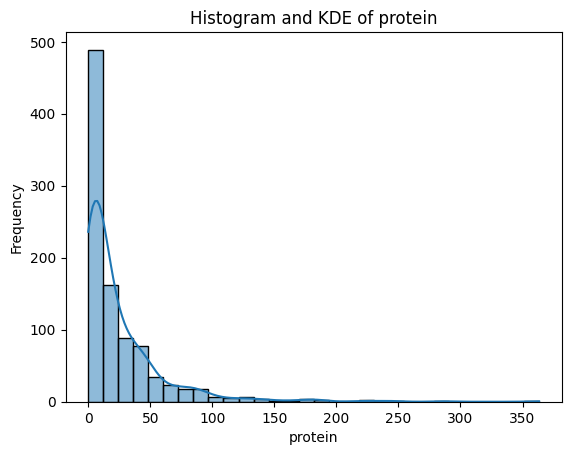

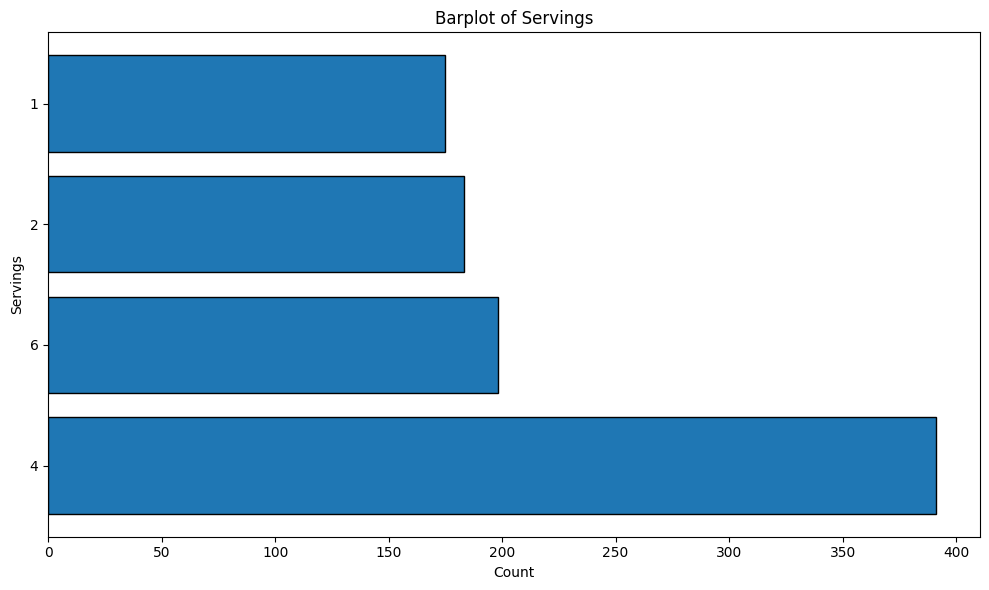

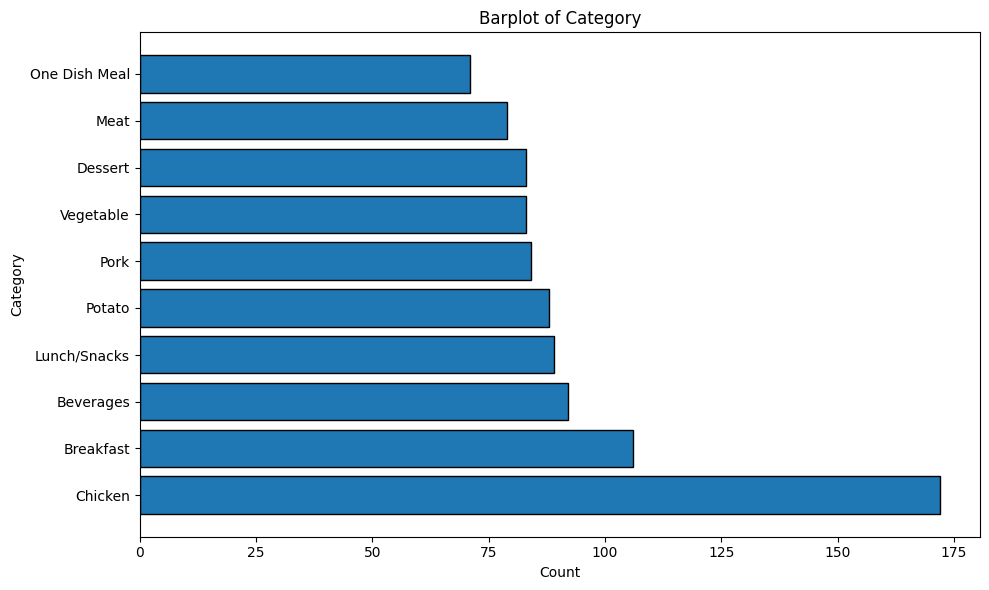

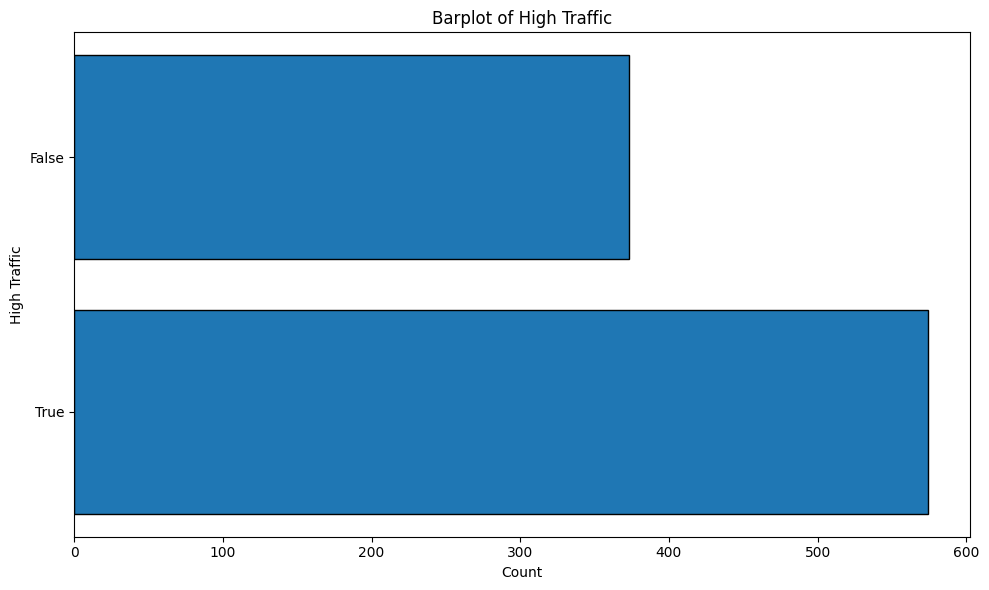

Percentage of True: 60.61%


In [13]:
# ============================================================================
# EXPLORATORY ANALYSIS - UNIVARIATE DISTRIBUTIONS
# ============================================================================
# Visualize distributions of numerical features
visualizer = DataVisualizer()

# Plot histograms for numerical columns
visualizer.plot_histogram(data=df_imputed, column="calories", bins=30)
visualizer.plot_histogram(data=df_imputed, column="carbohydrate", bins=30)
visualizer.plot_histogram(data=df_imputed, column="sugar", bins=30)
visualizer.plot_histogram(data=df_imputed, column="protein", bins=30)

# Plot barplots for categorical columns
visualizer.plot_barplot(data=df_imputed, column="servings")
visualizer.plot_barplot(data=df_imputed, column="category")
visualizer.plot_barplot(data=df_imputed, column="high_traffic")

# Calculate and display percentage of positive class
percentage_true = df_imputed["high_traffic"].mean() * 100
print(f"Percentage of True: {percentage_true:.2f}%")

**Comments on distribution analysis**
  
I created two types of graphics to visualize the distribution of the values in the columns. I used histogram for analysing the distribution of numerical columns and a horizontal barplot to visualize frequencies in categorical columns (as said at the beginning, servings has only 4 unique values, I treat it as a categorical).
- Interestingly, we can see how all the 4 numerical columns seem to show a right-skewed distribution, with the presence of some non-critical outliers
- The analysis of the categorical columns highlights how the most frequent serving is 4, the most frequent recipe category is chicken, and there are more True than False in the data.

**Very important: True occurs in 60.61% of the cases**, this means that the current human selection of the recipe to put in first page is able to detect a recipe with high web traffic interest in 60.61% of the cases.
I will now analyze correlations between the variables.

**Simple correlation analysis**

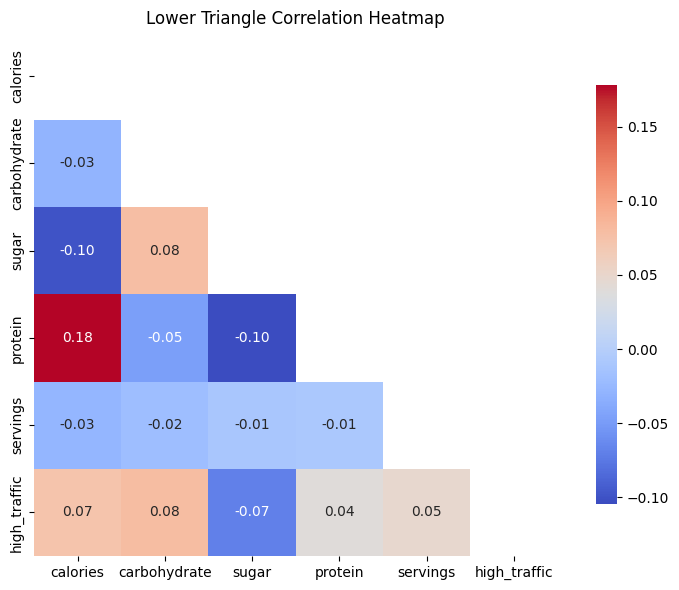

ANOVA test for imputed data
ANOVA for 'calories' by Category: F = 12.461, p = 0.000
ANOVA for 'carbohydrate' by Category: F = 12.297, p = 0.000
ANOVA for 'sugar' by Category: F = 53.819, p = 0.000
ANOVA for 'protein' by Category: F = 33.070, p = 0.000


{'calories': {'F-statistic': '12.461', 'p-value': '0.000'},
 'carbohydrate': {'F-statistic': '12.297', 'p-value': '0.000'},
 'sugar': {'F-statistic': '53.819', 'p-value': '0.000'},
 'protein': {'F-statistic': '33.070', 'p-value': '0.000'}}

In [14]:
# ============================================================================
# SIMPLE CORRELATION ANALYSIS - HEATMAP AND ANOVA
# ============================================================================
# Create lower triangle correlation heatmap
visualizer.plot_lower_triangle_heatmap(df=df_imputed, id_col="recipe", exclude_cols=["category"])

# Perform ANOVA tests to measure association with category
print("ANOVA test for imputed data")
StatisticalTester.anova_test_multiple(df=df_imputed, num_cols=num_cols, cat_col="category")

**First comments on correlation analysis**
- Correlations between the variables look all very low/modest, nothing interesting to note in the heatmap
- The ANOVA test stated a strong correlation between the 4 nutrional numerical columns and the category. Keep in mind for multicollinearity risks in linear models.

**Scatterplots between numerical columns**

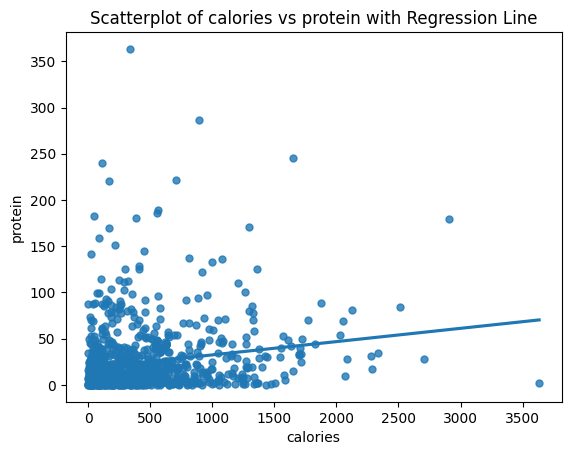

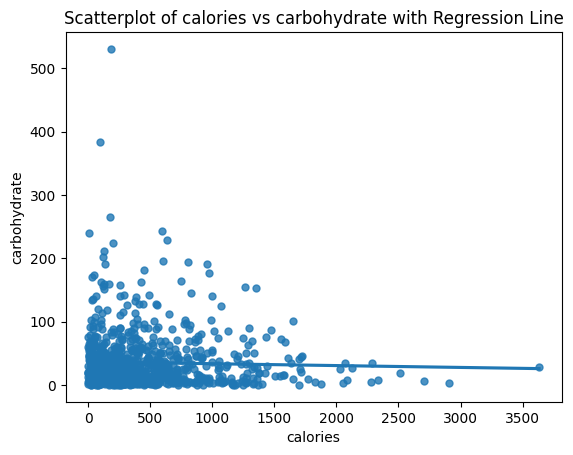

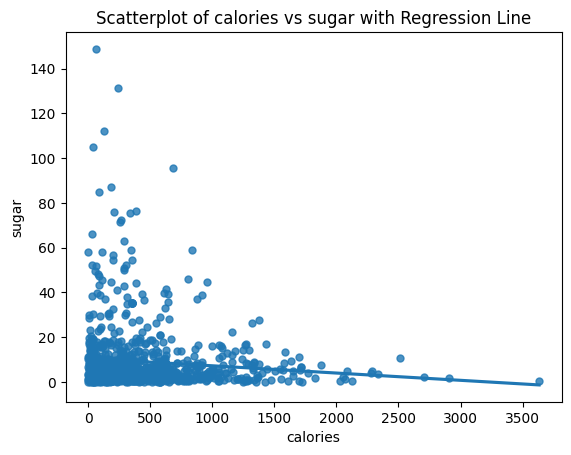

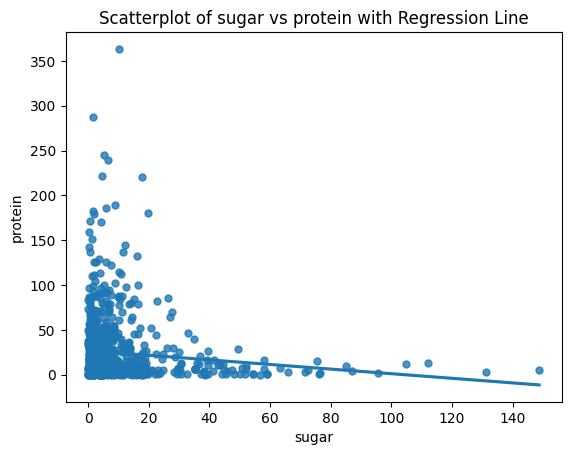

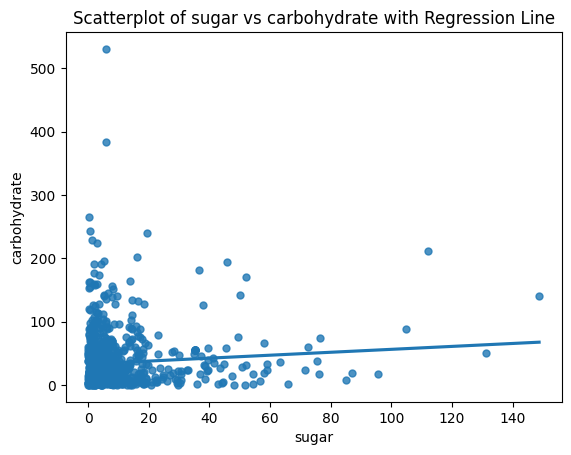

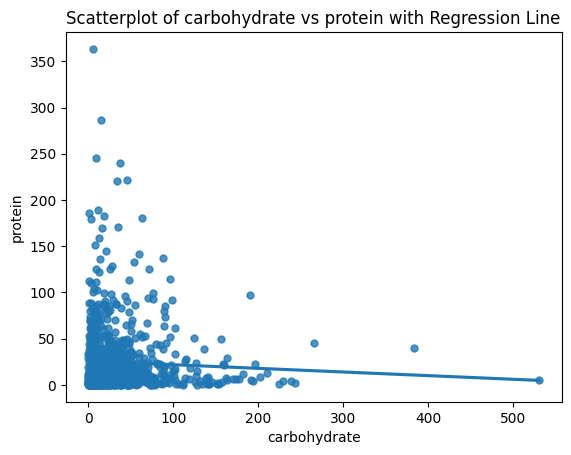

In [15]:
# ============================================================================
# PAIRWISE SCATTERPLOTS WITH REGRESSION LINES
# ============================================================================
# Visualize relationships between numerical features
visualizer.scatterplot_with_reg_line(data=df_imputed, x_col="calories", y_col="protein")
visualizer.scatterplot_with_reg_line(data=df_imputed, x_col="calories", y_col="carbohydrate")
visualizer.scatterplot_with_reg_line(data=df_imputed, x_col="calories", y_col="sugar")
visualizer.scatterplot_with_reg_line(data=df_imputed, x_col="sugar", y_col="protein")
visualizer.scatterplot_with_reg_line(data=df_imputed, x_col="sugar", y_col="carbohydrate")
visualizer.scatterplot_with_reg_line(data=df_imputed, x_col="carbohydrate", y_col="protein")

- Surprisingly the nutrition numerical columns show very modest correlation with each other. If they are used as features it should be done with a lot of attention because they might not add anything meaningful.

**Following analysis of the categorical columns correlation with our target.**

Chi-squared test between 'category' and 'high_traffic':
Chi2 statistic: 318.294
p-value:        0.000
Degrees of freedom: 9.000


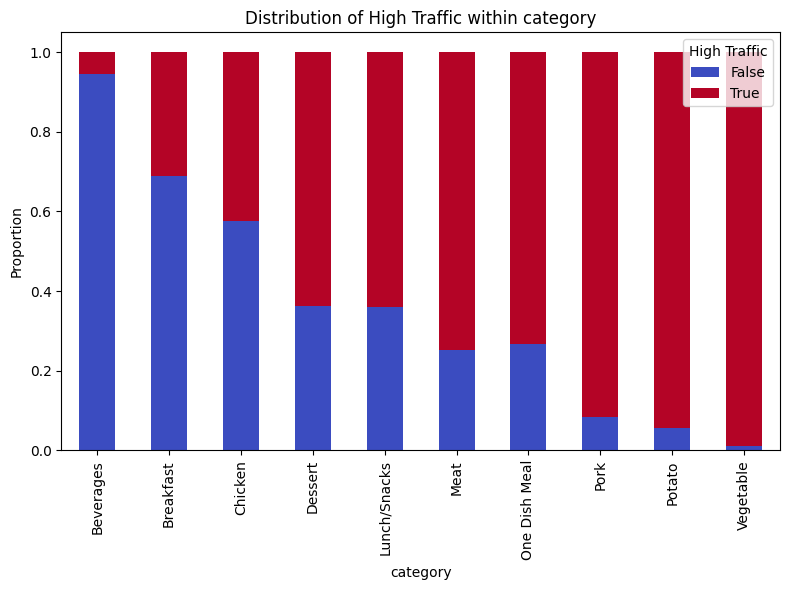

Chi-squared test between 'servings' and 'high_traffic':
Chi2 statistic: 2.737
p-value:        0.434
Degrees of freedom: 3.000


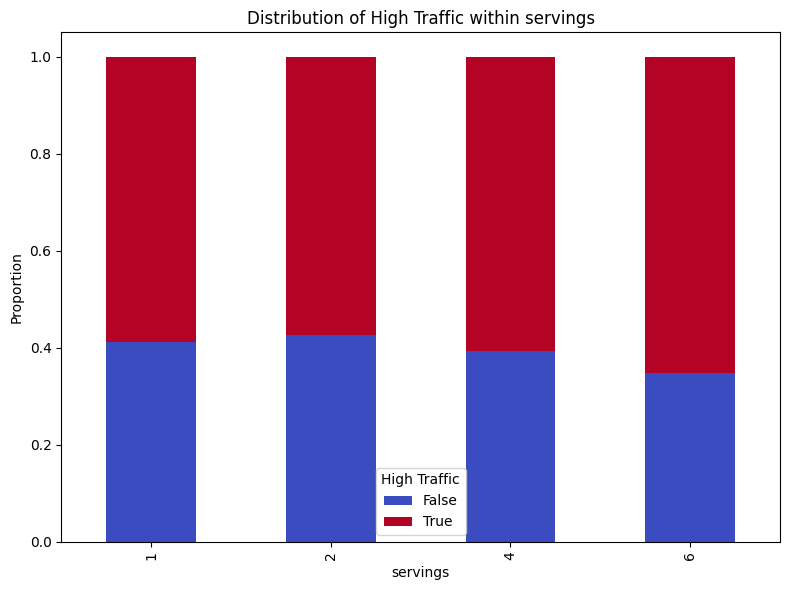

Chi-squared test between 'servings' and 'category':
Chi2 statistic: 29.920
p-value:        0.318
Degrees of freedom: 27.000


{'chi2_statistic': np.float64(29.92030321208159),
 'p_value': np.float64(0.3177466672002187),
 'degrees_of_freedom': 27,
 'contingency_table': category  Beverages  Breakfast  Chicken  Dessert  Lunch/Snacks  Meat  \
 servings                                                               
 1                20         26       36       17            17    14   
 2                17         21       30       15            15    15   
 4                34         41       72       30            36    36   
 6                21         18       34       21            21    14   
 
 category  One Dish Meal  Pork  Potato  Vegetable  
 servings                                          
 1                    13    10      15          7  
 2                    23    16      12         19  
 4                    24    37      38         43  
 6                    11    21      23         14  }

In [16]:
# ============================================================================
# CATEGORICAL FEATURES vs TARGET VARIABLE ANALYSIS
# ============================================================================
# Test association between category and target using chi-squared test
StatisticalTester.chi_squared_test(df=df_imputed, cat_col="category")
visualizer.plot_category_high_traffic(df=df_imputed, cat_col="category")

# Test association between servings and target
StatisticalTester.chi_squared_test(df=df_imputed, cat_col="servings")
visualizer.plot_category_high_traffic(df=df_imputed, cat_col="servings")

# Test association between servings and category
StatisticalTester.chi_squared_test(df=df_imputed, cat_col="servings", target_col="category")

**I have found the best candidate for being the main feature to predict the classification high_traffic**  

I used stacked bar graphs and chi2 test to test correlation between the categorical variables and the boolean outcome in my data.

- The column 'category' show a very high correlation with the outcome variable high_traffic. 
- We can see that the most popular recipe are in the categories vegetable, potato, and pork, while the least popular are beverages, breakfast, and chicken.
- The variable servings on the contrary does not show any correlation neither with categories nor with the traffic outcome

**Let's analyze the numerical features correlation**

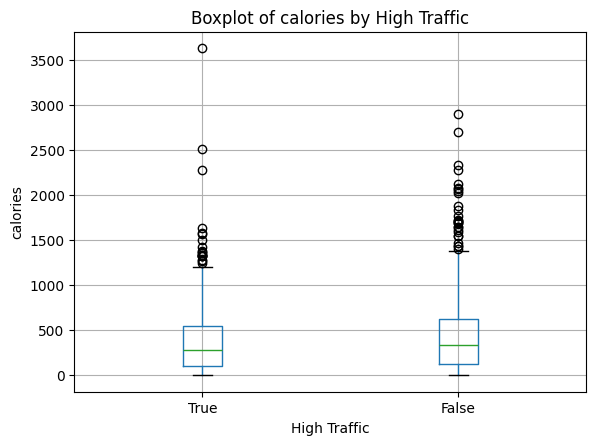

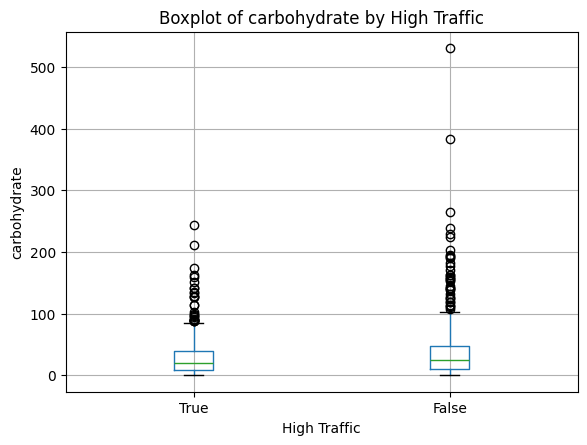

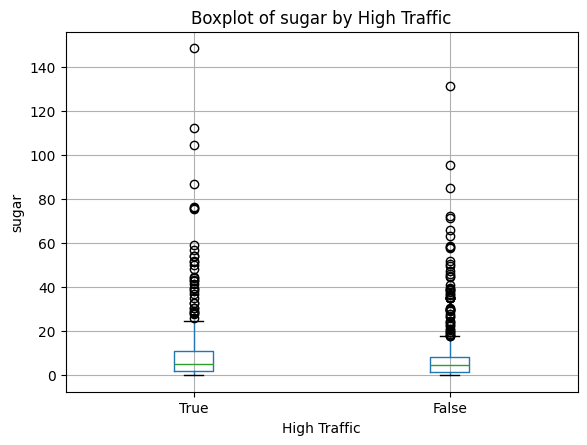

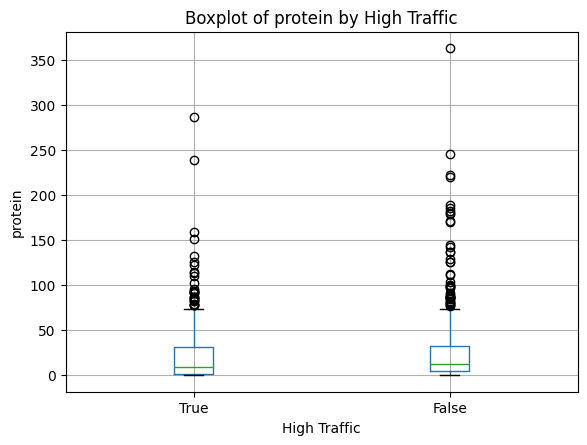

ANOVA for 'calories' by High Traffic: F = 4.965, p = 0.026
ANOVA for 'carbohydrate' by High Traffic: F = 6.042, p = 0.014
ANOVA for 'sugar' by High Traffic: F = 4.629, p = 0.032
ANOVA for 'protein' by High Traffic: F = 1.491, p = 0.222


{'calories': {'F-statistic': '4.965', 'p-value': '0.026'},
 'carbohydrate': {'F-statistic': '6.042', 'p-value': '0.014'},
 'sugar': {'F-statistic': '4.629', 'p-value': '0.032'},
 'protein': {'F-statistic': '1.491', 'p-value': '0.222'}}

In [17]:
# ============================================================================
# NUMERICAL FEATURES vs TARGET VARIABLE ANALYSIS
# ============================================================================
# Visualize distributions of numerical features across target groups using boxplots
visualizer.draw_boxplot(feature="calories", target="high_traffic", data=df_imputed)
visualizer.draw_boxplot(feature="carbohydrate", target="high_traffic", data=df_imputed)
visualizer.draw_boxplot(feature="sugar", target="high_traffic", data=df_imputed)
visualizer.draw_boxplot(feature="protein", target="high_traffic", data=df_imputed)

# Perform ANOVA tests to measure statistical significance of differences
StatisticalTester.anova_test_multiple(df=df_imputed, num_cols=num_cols, cat_col="high_traffic")

**First impressions**

I use boxplot visualizations to check graphically the correlation between numerical columns and boolean,none has been observed, but this graphical inspection is not able to detect non-linear patterns. The ANOVA test detect a not super strong, but significant correlation of the numerical columns with the outcome variable. I will investigate non-linear patterns with a scatterplot with jitter using binned means.

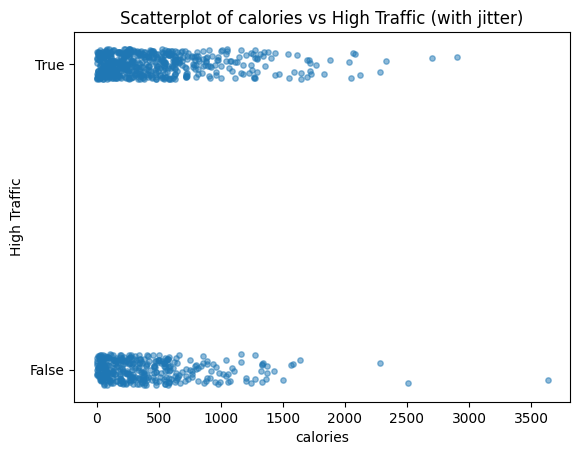

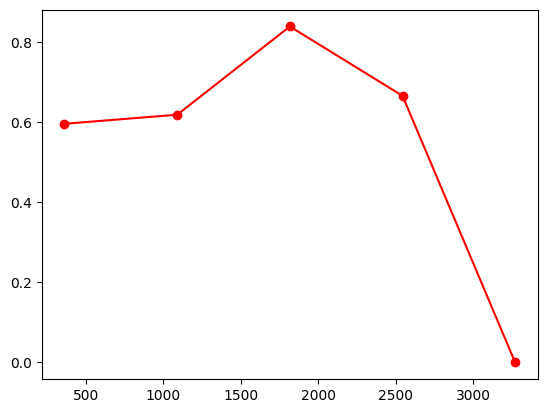

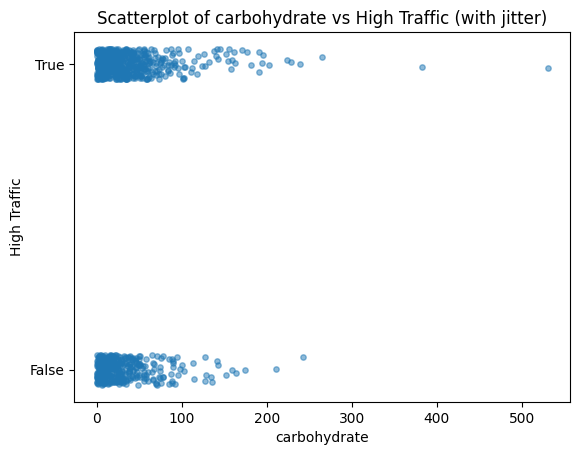

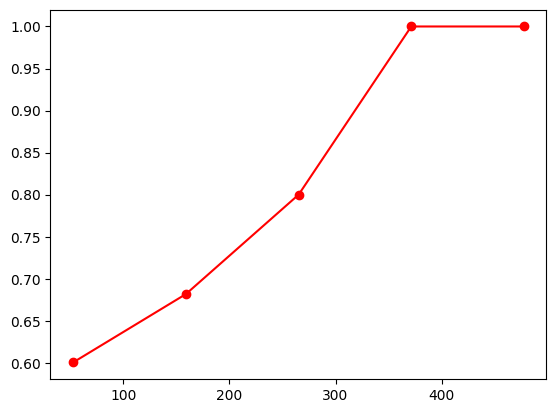

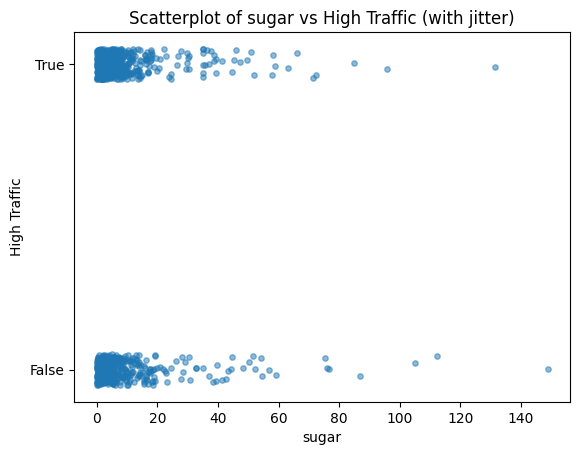

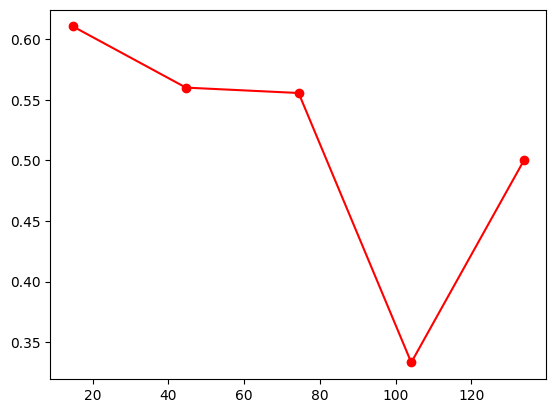

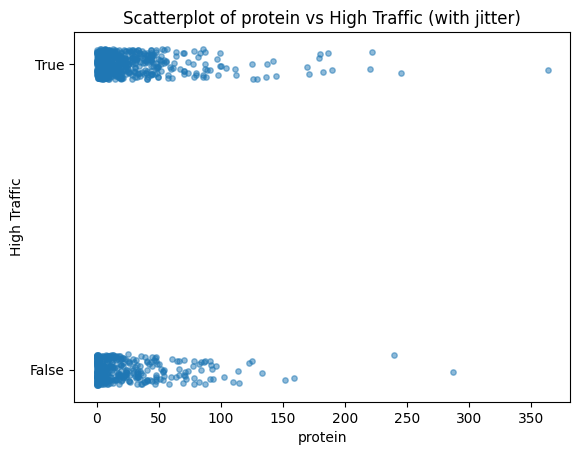

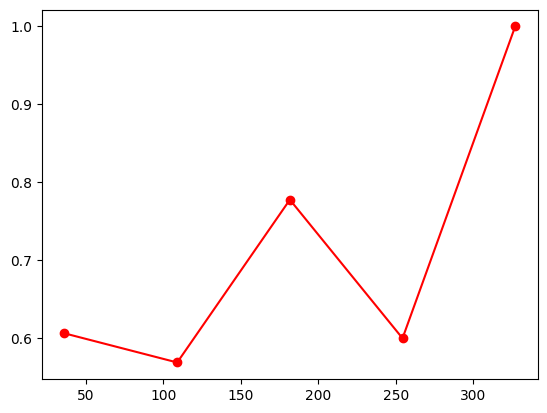

In [18]:
# ============================================================================
# NON-LINEAR RELATIONSHIP ANALYSIS WITH BINNED MEANS
# ============================================================================
# Create scatterplots with binned means to detect non-linear patterns
visualizer.scatterplot_with_binned_means(
    data=df_imputed, num_col="calories", target_col="high_traffic"
)
visualizer.scatterplot_with_binned_means(
    data=df_imputed, num_col="carbohydrate", target_col="high_traffic"
)
visualizer.scatterplot_with_binned_means(
    data=df_imputed, num_col="sugar", target_col="high_traffic"
)
visualizer.scatterplot_with_binned_means(
    data=df_imputed, num_col="protein", target_col="high_traffic"
)

**Possible small but significant non-linear correlation of the nutrional numerical columns**

It seems to exist a non-linear correlation between the nutritional numerical variables calories, carbohydrate, and sugar with the outcome. 
I want to double-check if this apparent non-linear relationship is driven somehow by the presence of outliers.

**Outliers analysis**

In [19]:
# ============================================================================
# OUTLIER DETECTION USING Z-SCORE METHOD
# ============================================================================
# Detect outliers within each category using z-score method
# This helps identify extreme values that might affect model training
for col in num_cols:
    # Calculate z-scores within each category
    df_imputed[f"{col}_zscore"] = df_imputed.groupby("category")[col].transform(zscore)

# Identify observations with z-score > 3 (extreme outliers) for each numerical feature
outliers_calories = df_imputed.loc[np.abs(df_imputed["calories_zscore"]) > 3]
outliers_carbohydrate = df_imputed.loc[np.abs(df_imputed["carbohydrate_zscore"]) > 3]
outliers_sugar = df_imputed.loc[np.abs(df_imputed["sugar_zscore"]) > 3]
outliers_protein = df_imputed.loc[np.abs(df_imputed["protein_zscore"]) > 3]

print("Outliers in calories:")
print(outliers_calories[num_cols + ["high_traffic", "category"]].head(25))
print("\nOutliers in carbohydrate:")
print(outliers_carbohydrate[num_cols + ["high_traffic", "category"]].head(25))
print("\nOutliers in sugar:")
print(outliers_sugar[num_cols + ["high_traffic", "category"]].head(25))
print("\nOutliers in protein:")
print(outliers_protein[num_cols + ["high_traffic", "category"]].head(25))

Outliers in calories:
     calories  carbohydrate  sugar  protein  high_traffic       category
49    1724.25         45.52   0.07    49.37          True      Breakfast
71    2508.47         18.11  10.60    84.23         False        Chicken
124   2906.01          3.52   1.89   179.22          True           Pork
155    836.95         32.82  59.04     0.32         False      Beverages
226   2703.12          6.40   2.17    28.20          True           Pork
330    684.88         41.08   2.00     1.48         False      Beverages
355   1337.71          3.84   8.48     0.95          True      Vegetable
356   2282.60          4.50   4.16    31.19          True  One Dish Meal
721   1588.26         67.84  13.43     5.84          True        Dessert
781   2068.07         34.23   1.46    10.02          True         Potato
811   1053.49          6.49  10.53    10.27          True      Vegetable
907   2332.32          7.47   3.62    34.33          True  One Dish Meal
925   3633.16         29.07  

In [20]:
# ============================================================================
# TEST IF OUTLIERS CORRELATE WITH TARGET VARIABLE
# ============================================================================
# Perform ANOVA tests on outliers to check if they have specific relationship with target
print("Test if outliers are correlated with our outcome variable")
StatisticalTester.anova_test_multiple(
    df=outliers_calories, num_cols=["calories"], cat_col="high_traffic"
)
StatisticalTester.anova_test_multiple(
    df=outliers_carbohydrate, num_cols=["carbohydrate"], cat_col="high_traffic"
)
StatisticalTester.anova_test_multiple(df=outliers_sugar, num_cols=["sugar"], cat_col="high_traffic")

Test if outliers are correlated with our outcome variable
ANOVA for 'calories' by High Traffic: F = 0.000, p = 0.984
ANOVA for 'carbohydrate' by High Traffic: F = 1.005, p = 0.329
ANOVA for 'sugar' by High Traffic: F = 0.015, p = 0.904


{'sugar': {'F-statistic': '0.015', 'p-value': '0.904'}}

**Results of the outliers analysis**

There are a few non-critical outliers, but they are not correlated with the outcome high_traffic, so they won't disturb the models.

It is now the time of planning the model development and feature selection and engineering.

**Small summary**

It must be noted that:
- protein and servings did not show any significant correlation pattern with the outcome
- category is the only column that show a very strong and clear correlation with the high_traffic column
- the other numerical columns calories, sugar, carbohydrate are highly correlated with the variable category which will be the main X in my models. This might create multicollinearity issues in linear models. 
- the numerical columns presented 52 outliers which have been imputed, and they have shown not clear correlation patterns
- **This task is a classification task because we need to predict if the recipes show high traffic or not**.

# Model Development

**Action plan**

I will train two models to correctly **classify** recipes. The first model will use Logistic Regression model and it will contain only an encoded version of the category column because linear models are not very robust to detect non-linear relationship and they are sensible to multicollinearity.

The second comparison model will be a Random Forest Classifier, with it I will try to model the modest non-linear relationship (If relevant) of the columns carbohydrate, sugar, and calories. If the non-linear part of the relation is relevant, it will improve the performance of the evaluation metrics. In addition, this model is robust to multicollinearity, so no problems will arise from the strong correlation between these numerical columns and the variable category.

I will then evaluate both of them considering mostly the recall and the precision because our business problem regards mostly being able to detect correctly all the popular recipes.

**Disclaimer**
I used RandomizedSearchCV for both of the Random Forest and Logistic Regression to find the best combination of fine-tuning parameters given ranges and possibilities that are considered state-of-the-art (or standard) for this type of classification problem. However, for reproducibility of the results, I only report here the best-fitted model; I decided to follow this strategy because running the RandomizedSearchCV will always result in slight and negligible differences, but still might damage perfect reproducibility.

For transparency reasons, I leave as commented lines the code for the Randomized Search.

Now is the time of **feature engineering and train test splitting**

In [21]:
# ============================================================================
# FEATURE SELECTION FOR MODEL DEVELOPMENT
# ============================================================================
# Select relevant features for model training
# Features include numerical nutritional data and categorical recipe type
X = df_imputed[["calories", "sugar", "carbohydrate", "category"]].copy()
y = df_imputed["high_traffic"].copy()

# Verify data integrity before modeling
print(X.info())
print(y.info())
print("\nUnique category values:")
print(X["category"].unique())
print(X["category"].value_counts())

<class 'pandas.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   calories      947 non-null    float64
 1   sugar         947 non-null    float64
 2   carbohydrate  947 non-null    float64
 3   category      947 non-null    string 
dtypes: float64(3), string(1)
memory usage: 29.7 KB
None
<class 'pandas.Series'>
RangeIndex: 947 entries, 0 to 946
Series name: high_traffic
Non-Null Count  Dtype
--------------  -----
947 non-null    bool 
dtypes: bool(1)
memory usage: 1.1 KB
None

Unique category values:
<StringArray>
[         'Pork',        'Potato',     'Breakfast',     'Beverages',
 'One Dish Meal',       'Chicken',  'Lunch/Snacks',     'Vegetable',
          'Meat',       'Dessert']
Length: 10, dtype: string
category
Chicken          172
Breakfast        106
Beverages         92
Lunch/Snacks      89
Potato            88
Pork              84
Vegetable         83
Desser

In [22]:
# ============================================================================
# FEATURE ENGINEERING
# ============================================================================
# Prepare features for modeling with log transformation and one-hot encoding
X_transformed = fe.prepare_features_for_modeling(
    X, numerical_cols=["calories", "sugar", "carbohydrate"], categorical_cols=["category"]
)

# Display first 5 rows of feature-engineered data
print("Feature-engineered data (first 5 rows):")
print(X_transformed.head())

Feature-engineered data (first 5 rows):
   calories  sugar  carbohydrate  calories_log  sugar_log  carbohydrate_log  \
0    629.71   8.04         28.08      6.446846   2.201659          3.370051   
1     35.48   0.66         38.56      3.596764   0.506818          3.677819   
2    914.28   3.09         42.68      6.819230   1.408545          3.776890   
3     97.03  38.63         30.56      4.585274   3.679586          3.451890   
4     27.05   0.80          1.85      3.333989   0.587787          1.047319   

   category_Beverages  category_Breakfast  category_Chicken  category_Dessert  \
0               False               False             False             False   
1               False               False             False             False   
2               False                True             False             False   
3                True               False             False             False   
4                True               False             False             False   

**Summary of feature engineering**
In the feature engineering part I: 
- selected all relevant columns
- created log functions of the numerical features to penalize the weight of outliers
- one hot encoded the category column

I will now split the data in train and test sets and create the final training and test data for my two models

In [23]:
# ============================================================================
# TRAIN-TEST SPLIT AND DATA PREPARATION
# ============================================================================
# Split data into training (75%) and testing (25%) sets with random seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, train_size=0.75, random_state=42, shuffle=True
)

# Define column names for different feature sets
nutrition_columns_raw = ["calories", "sugar", "carbohydrate"]
nutrition_columns_logs = ["calories_log", "sugar_log", "carbohydrate_log"]

# Prepare different dataset configurations for different models
(X_train_without_nutr, X_test_without_nutr, X_train_with_log, X_test_with_log) = (
    fe.prepare_train_test_datasets(
        X_train,
        X_test,
        numerical_cols_raw=nutrition_columns_raw,
        numerical_cols_logs=nutrition_columns_logs,
    )
)

## Logistic Regression - Training

The split has been done, let's start training the logistic regression benchmark model.
I used f1 as scoring criteria in the Randomized Search because I am more concerned about finding all positives
with the lowest error possible in predicting positives. I used broadly accepted ranges for the parameters fine-tuning of such a model.
I only use categories as "X" to avoid multicollinearity since the numerical columns are strongly correlated with the category as we saw in the exploratory analysis.

Remember, the commented lines are for the Randomized Search, but I want reproducibility, so after I found out the best parameters I just commented the lines and hard-coded the parameters.

In [24]:
# ============================================================================
# LOGISTIC REGRESSION MODEL - TRAINING
# ============================================================================
# Initialize and train Logistic Regression model using category features only
# This avoids multicollinearity while providing a simple, interpretable baseline
logreg_wrapper = LogisticRegressionModel(
    solver="lbfgs", penalty="l2", l1_ratio=0.75, C=109.85411419875572, max_iter=10000
)

# Fit model on training data
logreg_wrapper.fit(X_train_without_nutr, y_train)

# Make predictions on both training and test sets
y_pred_logreg_train = logreg_wrapper.predict(X_train_without_nutr)
y_proba_train = logreg_wrapper.predict_proba(X_train_without_nutr)[:, 1]

y_pred_logreg_test = logreg_wrapper.predict(X_test_without_nutr)
y_proba_test = logreg_wrapper.predict_proba(X_test_without_nutr)[:, 1]

# Calculate evaluation metrics for training set
metrics_logreg_train = ModelEvaluator.calculate_metrics(y_train, y_pred_logreg_train, y_proba_train)

# Calculate evaluation metrics for test set
metrics_logreg_test = ModelEvaluator.calculate_metrics(y_test, y_pred_logreg_test, y_proba_test)

# Print detailed evaluation report
ModelEvaluator.print_metrics_report(
    "Logistic Regression", metrics_logreg_train, metrics_logreg_test
)


Logistic Regression - Evaluation Report

TRAINING SET METRICS:
------------------------------
Accuracy       : 0.7606
Precision      : 0.7972
Recall         : 0.8047
Roc_auc        : 0.8326

TEST SET METRICS:
------------------------------
Accuracy       : 0.7679
Precision      : 0.8176
Recall         : 0.8121
Roc_auc        : 0.8273



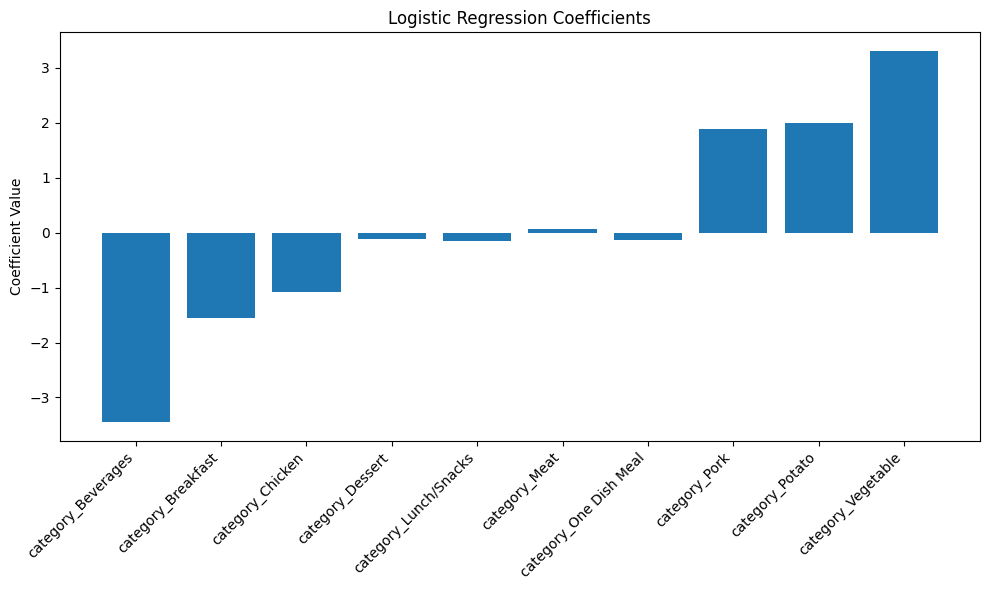

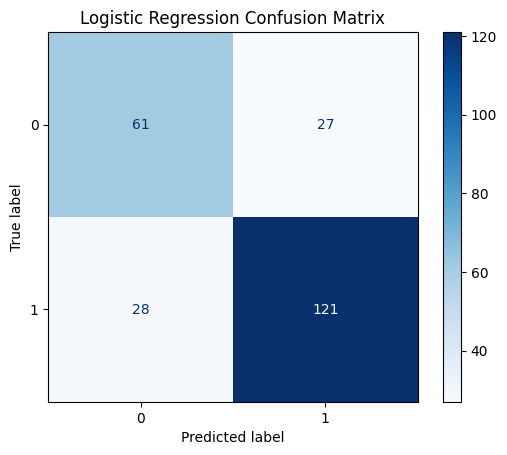

Logistic Regression Coefficients Table:
                   Feature  Coefficient
0                Intercept     0.784236
1       category_Beverages    -3.450645
2       category_Breakfast    -1.555697
3         category_Chicken    -1.085991
4         category_Dessert    -0.114904
5    category_Lunch/Snacks    -0.159651
6            category_Meat     0.069177
7   category_One Dish Meal    -0.124814
8            category_Pork     1.889719
9          category_Potato     1.999350
10      category_Vegetable     3.309313


In [25]:
# ============================================================================
# LOGISTIC REGRESSION MODEL - VISUALIZATION AND INTERPRETATION
# ============================================================================
# Visualize the coefficients of the logistic regression model
model_viz = ModelVisualizer()
model_viz.plot_logistic_coefficients(logreg_wrapper.model, X_train_without_nutr.columns)

# Plot confusion matrix for test set predictions
visualizer.plot_confusion(
    y_pred=y_pred_logreg_test,
    y_true=y_test,
    title="Logistic Regression Confusion Matrix",
)

# Create and display table of model coefficients for interpretation
features_table = list(X_train_without_nutr.columns)
table = ModelInterpreter.logistic_regression_table(logreg_wrapper.model, features_table)
print("Logistic Regression Coefficients Table:")
print(table)

## Logistic Regression - Initial model evaluation

Very good results have been reached. The recall on the test set is 0.812, and the precision on the test set is 0.817. The evaluation metrics between training and test set are very similar, actually slightly better on the test set, indicating that there is no overfitting. This model satisfies the business request, but I want to try a more sophisticated model using Random Forest, and more features to model non-linear relationship observed in the numerical features without to worry too much about multicollinearity.

## Random Forest Classifier - Training

I used f1 as scoring criteria in the Randomized Search because I am more concerned about finding all positives
with the lowest error possible in predicting positives. I used broadly accepted ranges for the parameters fine-tuning of such a model.

I also use logged numerical features because they presented a right-skewed distribution. Random Forest is more robust to multicollinearity and to non-linear relationships, so no need to worry about that.

Remember, the commented lines are for the Randomized Search, but I want reproducibility, so after I found out the best parameters I just commented the lines and hard-coded the parameters.

In [26]:
# ============================================================================
# RANDOM FOREST CLASSIFIER MODEL - TRAINING
# ============================================================================
# Initialize and train Random Forest model using all features including numerical
# Random Forest is robust to multicollinearity and can capture non-linear relationships
rf_wrapper = RandomForestModel(
    n_estimators=10,
    min_samples_split=15,
    min_samples_leaf=1,
    max_features="log2",
    max_depth=None,
    class_weight=None,
    bootstrap=True,
)

# Fit model on training data with log-transformed numerical features
rf_wrapper.fit(X_train_with_log, y_train)

# Make predictions on both training and test sets
y_pred_rf_train = rf_wrapper.predict(X_train_with_log)
y_proba_rf_train = rf_wrapper.predict_proba(X_train_with_log)[:, 1]

y_pred_rf_test = rf_wrapper.predict(X_test_with_log)
y_proba_rf_test = rf_wrapper.predict_proba(X_test_with_log)[:, 1]

# Calculate evaluation metrics for training set
metrics_rf_train = ModelEvaluator.calculate_metrics(y_train, y_pred_rf_train, y_proba_rf_train)

# Calculate evaluation metrics for test set
metrics_rf_test = ModelEvaluator.calculate_metrics(y_test, y_pred_rf_test, y_proba_rf_test)

# Print detailed evaluation report
ModelEvaluator.print_metrics_report("Random Forest Classifier", metrics_rf_train, metrics_rf_test)


Random Forest Classifier - Evaluation Report

TRAINING SET METRICS:
------------------------------
Accuracy       : 0.8507
Precision      : 0.8633
Recall         : 0.8918
Roc_auc        : 0.9375

TEST SET METRICS:
------------------------------
Accuracy       : 0.7089
Precision      : 0.7667
Recall         : 0.7718
Roc_auc        : 0.7862



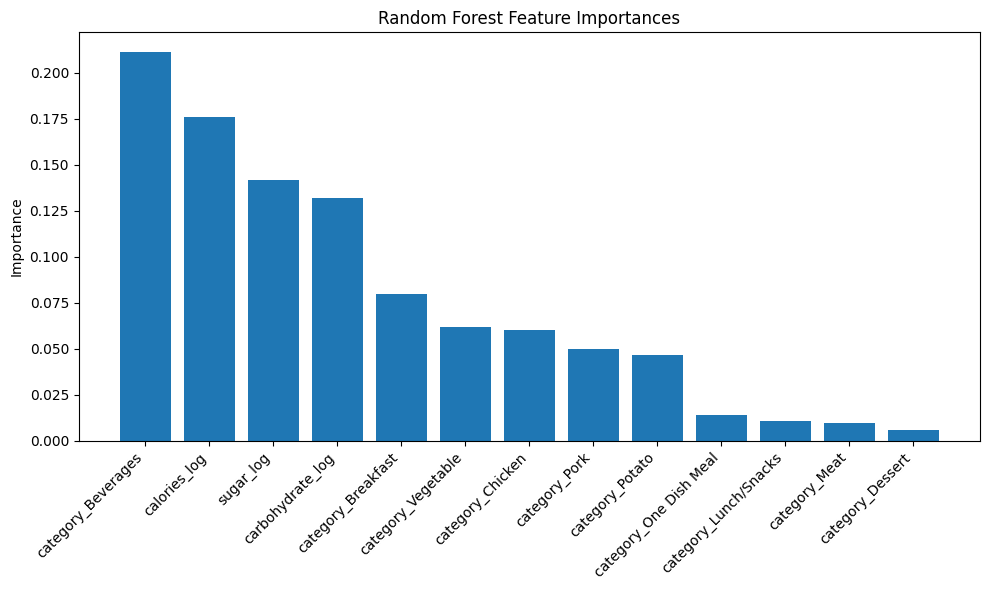

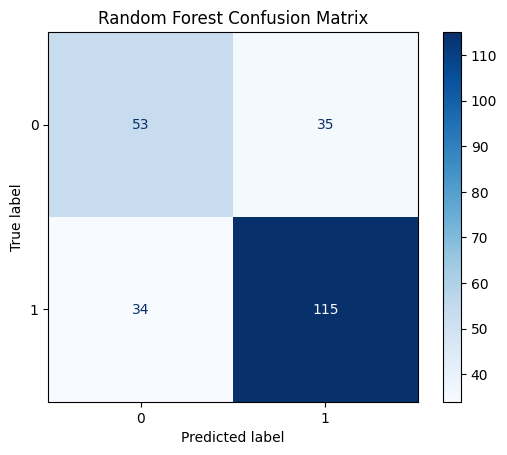

In [27]:
# ============================================================================
# RANDOM FOREST CLASSIFIER MODEL - VISUALIZATION AND INTERPRETATION
# ============================================================================
# Visualize feature importances from Random Forest
model_viz.plot_feature_importance_rf(model=rf_wrapper.model, feature_names=X_train_with_log.columns)

# Plot confusion matrix for test set predictions
visualizer.plot_confusion(
    y_pred=y_pred_rf_test,
    y_true=y_test,
    title="Random Forest Confusion Matrix",
)

## Random Forest Classifier - Initial model evaluation

No significative improvements from the logistics regression. Actually there was a slight decrease in all the model evaluation metrics (accuracy, precision, recall, and ROC AUC score). Evaluation metrics look better on the training set, this means that the Random Forest model suffers of moderate overfitting. I am mostly focused on recall and precision and these two metrics went down in the test set in relation to the benchmark model.

# Model evaluation - Summary

**Comparison**

Final evaluation compares only metrics obtained from the **test set** between the two models.

In addition to the previously mentioned initial model evaluation,
the baseline Logistic Regression model has correctly labeled 121/149 True observations and it erroneously labeled as positives only 27 observations. On the comparison, the Random Forest Classifier has correctly found fewer True observations, and it erroneously labeled more observations as positives as shown in the confusion matrix picture. Lastly, the logistic regression model is a very efficient and parsimonious model, in fact does not suffer of overfitting. Differently the random forest model suffers of a moderate overfitting. It is clear that the best model is the benchmark Logistic Regression model. The business should use it for selecting which recipes should go on the first page of the website to increase the web traffic. 

# Business metrics

The two main general questions coming from business were: 
- Predict which recipes will lead to high traffic?
- Correctly predict high traffic recipes 80% of the time?

The first question refers to the recall of a classification model (model’s ability to capture all relevant positive cases). The second question refers to the precision of a classification model (It is the proportion of true positive results among all instances the model predicted as positive). Therefore is vital for the business to monitor constantly the precision and the recall of the best model, and in case of deterioration of the performances update the model. In addition, the business should monitor the coefficients of the model, as of now in the table coefficient table and visualization shown above, the categories that most are able to predict a popular recipe are pork, potato, and vegetable. The least popular are beverages, breakfast and chicken.

Another metric to monitor for the business is the actual increase of web traffic. From the exploratory analysis above, I found out that the old only human based classification system was able to find the popular recipes in 60.61% of the cases. My model is able to predict with more than 80% precision what will be a popular recipe able to generate as much as 40% increase in the website. Therefore, implementing my model will lead as of now to an overall web traffic increase on average of up to 40 * precision (0.817) - 40 * 0.606 =  8.44% in relation to the currently only human-generated choice of the first page recipe. Business should monitor if after implementation of this model there is an increase of web traffic in the dimension of what I estimated. This estimation is of course to be taken as an estimation keeping all other factors constant. If the performance of this KPI should change over time the model should be updated, or the reasons of why the performance changed should be furtherly investigated.

# Final summary

The data has been properly cleaned and imputed to allow me to perform a proper analysis. From the exploratory analysis the main take away was the very high correlation of category in predicting whether a recipe is going to be popular or not. Two models were trained and compared. The Logistic Regression model outperforms the Random Forest Classifier by achieving higher recall and fewer false positives. Random Forest Classifier model suffers also of moderate overfitting. This makes Logistic Regression the recommended model for selecting recipes that should appear on the website’s first page to maximize traffic.

The business should monitor recall and precision, as these directly map to the company’s goals of identifying high-traffic recipes and ensuring predictions have high precision. Model coefficients should also be tracked, since key predictors of popular recipes are categories like pork, potato, and vegetable, but things can change and the model needs to stay updated with the current tastes.

Additionally, the last business impact metric to evaluate is the increase in web traffic. Compared to the old human-based system (60.61% precision), the new model is estimated to increase traffic by about 8.44%, assuming other factors remain constant. Continuous monitoring of this KPI is necessary, and if results deviate, either the model must be updated or the reasons behind performance changes must be investigated.

## Business Recommendations:

- Deploy the Logistic Regression model for homepage recipe selection.
- Track precision, recall, and web traffic increases monthly.
- Review feature importances (model coefficients) for emerging popular categories. At the moment they are vegetable, pork, potato. Keep in mind that right now the recipes in the categories of beverages, chicken and breakfast are not very popular. 
- You can design an A/B test experiment to figure it out if this model really works as intended in predicting popular recipes and finally increase web traffic.
- Update or retrain the model if KPIs change or model performance deteriorates.
Adopting these recommendations will ensure selection precision, enable ongoing improvements, and help the business meet its traffic goals.